# Convolution Neural Network Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

In [2]:
# Build X and y datasets

In [3]:
i = 0 # Initialize row index
folder = 'spectrogram_mini/'

# Count the number of items and determine the shape of the items:
num_items = 0
for subfolder in os.listdir(folder):
    path = folder + subfolder + '/'
    num_items += len(os.listdir(path)) # Add the number of items in the subfolder to the total number of items

print('The number of items in the folder is: %i' % num_items)

# Initialize X and y arrays:
X = np.empty((num_items, 135, 71))   
y = []

print(f'The shape of the X array is: {X.shape}')

The number of items in the folder is: 8000
The shape of the X array is: (8000, 135, 71)


In [4]:
# Create the X and y arrays:
i = 0
j =0
for subfolder in os.listdir(folder): # Check each subfolder in folder
    j += 1
    path = folder + subfolder + '/'
    print('Currently loading the \033[1m%s\033[0m subfolder... (%i/%i)        ' % (subfolder, j, len(os.listdir(folder))), end = '\r')
    
    # Loop over each numpy array in the subfolder:
    for item in os.listdir(path): 
        
        # Load the spectrogram data from the current numpy array.
        data = np.load(path + item) 
        
        # Check if the data contains infinite values:
        if np.isinf(data).sum() > 0:
            X = np.delete(X, i, 0) # If infinite values, drop the row from the X array.
        
        # If no infinite values, continue processing data:
        else:
            # Scale the data so the values are between 0 and 1:
            data = data - data.min()
            data = data/data.max()
            
            # Check that the data has the correct shape:
            if data.shape != (135,71):
                
                # If the data has less rows:
                if data.shape[1] < 71:
                    X[i,:,:] = 0 # Write a basleine value of the minimum value of the array.
                    X[i,:data.shape[0], :data.shape[1]] = data # Overwrite the first values of the X array with the data from the spectrogram.
                
                # If the data has more rows:
                else:
                    X[i,:,:] = data[:135,:71] # Take only the first 135 rows and 71 columns from the data.
                    
            # If data has the correct number of rows:
            else:
                X[i,:,:] = data # Save the spectrogram data to the appropriate row in the X array.
            
            
            # Append the spoken word to the y data:
            y.append(subfolder)
        
            i += 1 # Add one to the row counter.

print('Done!                                                  ', end = '\r')

In [5]:
print(f'The shape of the X array is: {X.shape}')
print(f'The length of the y array is: {len(y)}')

The shape of the X array is: (7700, 135, 71)
The length of the y array is: 7700


## Inspect the Data

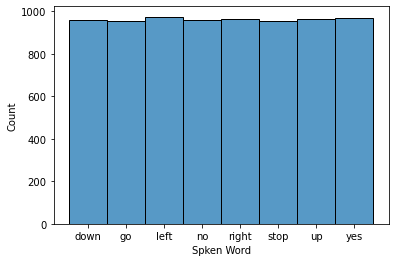

In [6]:
# Check the distribution of different spoken words:
sns.histplot(y)
plt.xlabel('Spken Word')
plt.show()

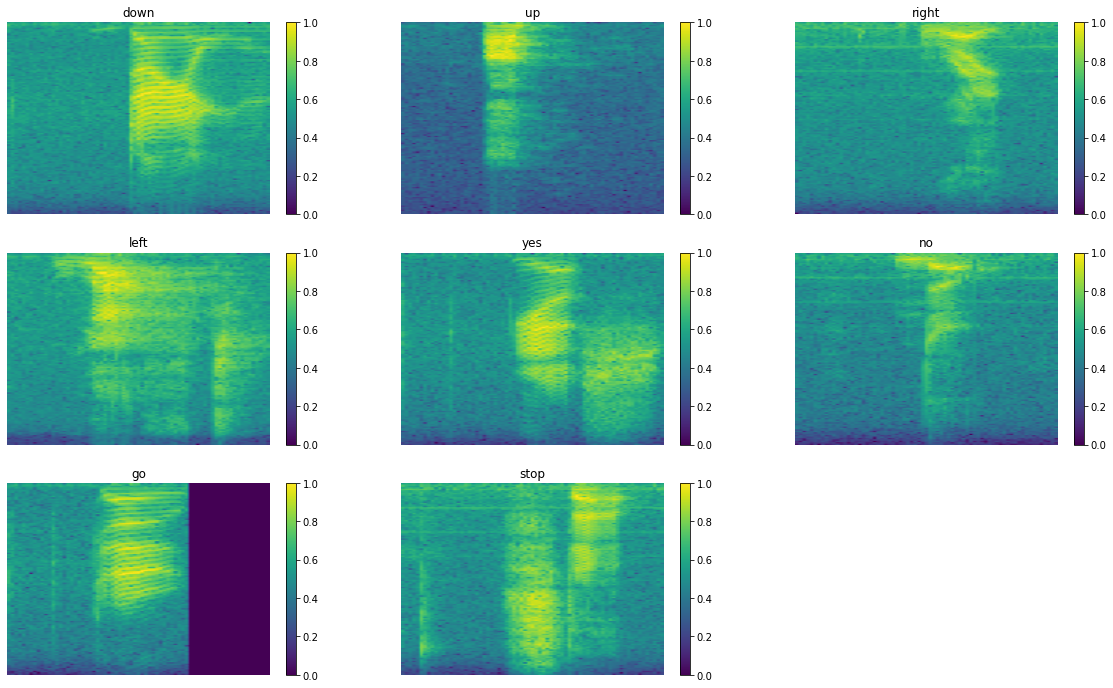

In [7]:
# 
plt.figure(figsize=(20, 12))
i = 0  
for label in set(y):
        j = y.index(label)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[j], aspect= 'auto')
        plt.title(y[j])
        plt.axis("off")
        plt.colorbar()
        i += 1

plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

# Reshape for Keras model types
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (6160, 135, 71, 1)
y_train shape: (6160,)
X_test shape: (1540, 135, 71, 1)
y_test shape: (1540,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [10]:
CNN_model = Sequential()
num_classes = len(set(y_train))
# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model.add(Conv2D(filters = 32, kernel_size=(3, 3), activation = 'relu', input_shape = (135, 71, 1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(filters = 64, kernel_size=(3, 3), activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(filters = 128, kernel_size=(3, 3), activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(filters = 256, kernel_size=(3, 3), activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten())

# Add dense layers
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(64, activation = 'relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dense(num_classes, activation='softmax'))

# Print out a summary of the network
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 69, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 34, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 66, 34, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 16, 64)       0         
 2D)                                                             
                                                        

In [11]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [12]:
history = CNN_model.fit(X_train, y_train,
              batch_size = 32,
              epochs = 20,
              verbose = 1,
              validation_split = 0.2)

Epoch 1/30
154/154 [==============================] - 84s 531ms/step - loss: 1.6035 - accuracy: 0.4255 - val_loss: 2.2830 - val_accuracy: 0.1144
Epoch 2/30
154/154 [==============================] - 81s 528ms/step - loss: 0.9223 - accuracy: 0.6729 - val_loss: 2.2371 - val_accuracy: 0.1250
Epoch 3/30
154/154 [==============================] - 78s 509ms/step - loss: 0.6450 - accuracy: 0.7760 - val_loss: 1.7518 - val_accuracy: 0.3588
Epoch 4/30
154/154 [==============================] - 74s 477ms/step - loss: 0.5161 - accuracy: 0.8261 - val_loss: 0.6607 - val_accuracy: 0.7735
Epoch 5/30
154/154 [==============================] - 85s 555ms/step - loss: 0.4343 - accuracy: 0.8539 - val_loss: 0.8266 - val_accuracy: 0.7492
Epoch 6/30
154/154 [==============================] - 82s 531ms/step - loss: 0.3460 - accuracy: 0.8817 - val_loss: 0.4974 - val_accuracy: 0.8369
Epoch 7/30
154/154 [==============================] - 75s 490ms/step - loss: 0.3012 - accuracy: 0.9008 - val_loss: 0.6218 - val_ac

KeyboardInterrupt: 

In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values,  label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, label='Training accuracy')
plt.plot(epochs, val_acc_values, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model's performance on the test data
score = CNN_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
y_pred = CNN_model.predict(X_test).argmax(axis = 1)
matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (12, 8.5))
sns.heatmap(matrix, cmap = 'Reds', annot = True, fmt = 'g')
plt.yticks(ticks = np.array(range(8)) + 0.5, labels = le.inverse_transform(range(8)))
plt.xticks(ticks = np.array(range(8)) + 0.5, labels = le.inverse_transform(range(8)))
plt.show()

In [ ]:
CNN_model2 = Sequential()
num_classes = len(set(y_train))
# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model2.add(Conv2D(filters = 32, kernel_size=(3, 3), activation = 'relu', input_shape = (135, 71, 1)))
CNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model2.add(BatchNormalization())
CNN_model2.add(Conv2D(filters = 64, kernel_size=(3, 3), activation = 'relu'))
CNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model2.add(BatchNormalization())
CNN_model2.add(Conv2D(filters = 128, kernel_size=(3, 3), activation = 'relu'))
CNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model2.add(BatchNormalization())
CNN_model2.add(Conv2D(filters = 256, kernel_size=(3, 3), activation = 'relu'))
CNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model2.add(BatchNormalization())
CNN_model2.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN_model2.add(Flatten())

# Add dense layers
CNN_model2.add(Dense(512, activation='relu'))
CNN_model2.add(BatchNormalization())
CNN_model2.add(Dropout(0.5))
CNN_model2.add(Dense(64, activation = 'relu'))
CNN_model2.add(BatchNormalization())
CNN_model2.add(Dense(num_classes, activation='softmax'))

# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model2.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

history = CNN_model2.fit(X_train, y_train,
              batch_size = 32,
              epochs = 10,
              verbose = 1)

In [ ]:
# Evaluate the model's performance on the test data
score = CNN_model2.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
y_pred2 = CNN_model2.predict(X_test).argmax(axis = 1)
matrix = confusion_matrix(y_test, y_pred2)

plt.figure(figsize = (12, 8.5))
sns.heatmap(matrix, cmap = 'Reds', annot = True, fmt = 'g')
plt.yticks(ticks = np.array(range(8)) + 0.5, labels = le.inverse_transform(range(8)))
plt.xticks(ticks = np.array(range(8)) + 0.5, labels = le.inverse_transform(range(8)))
plt.show()

In [ ]:
# save the classifier and scaler
CNN_model2.save_weights('models/cnn_weights')
pickle.dump(le, open('models/label_encoder.sav', 'wb'))